# Cleaning Modes With Rational Filters

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as pl
import numpy as np
import qnm_filter
import qnm
from gwpy.timeseries import TimeSeries
import copy
from scipy.special import logsumexp
import astropy.constants as c

## Data

In [3]:
theoretical_values = [50, 0.69]

In [4]:
omega, A, C = qnm.modes_cache(s=-2, l=2, m=2, n=0)(a=theoretical_values[1])
T_MSUN = c.M_sun.value * c.G.value / c.c.value**3

In [5]:
srate = 4096
t_range_prepad = np.linspace(0,0.5, int(srate/2), endpoint = False)
heaviside = np.heaviside(t_range_prepad, 1)
temp = 1e-22*np.exp(-1j*omega*t_range_prepad/(theoretical_values[0]*T_MSUN))
signal_prepad = np.real(temp*heaviside)
t_range = np.linspace(0,1, srate, endpoint = False)
signal = np.pad(signal_prepad, (int(srate/4),int(srate/4)))
noise = 1e-23*np.random.normal(size = srate)

(0.245, 0.265)

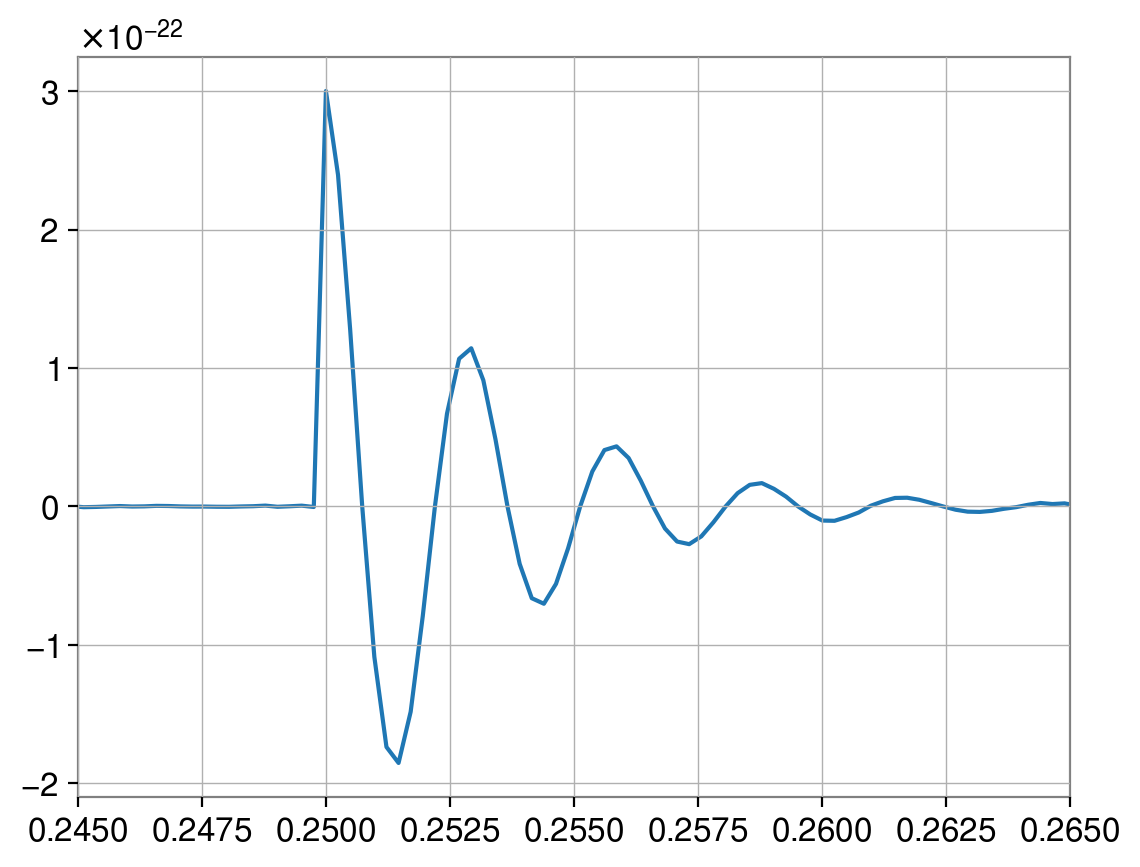

In [6]:
data = 3*(signal + 0.01*noise)
pl.plot(t_range, data)
pl.xlim(0.245, 0.265)

## Filter

In [15]:
mass = qnm_filter.Filter.mass_unit(theoretical_values[0])

In [16]:
input = dict(model_list = [(2,2,0, 'p')], #l, m, n
             # trucation time (geocenter, in second)
             t_init = 0.25+3*mass, #Calculated from SNR+t_init notebook
             # length of the analysis window (in second)
             segment_length = 0.2,
             # sampling rate after conditioning (in Hz)
             srate = 4096,
             # sky localization
             ra = None, dec = None,
             # lower limit of the high-pass filter (in Hz)
             flow = 20)

fit = qnm_filter.Network(**input)

Load data

In [76]:
signal_scale = 1
noise_scale = 0.0001
data = signal_scale*signal + noise_scale*noise

In [77]:
fit.original_data['H1'] = qnm_filter.RealData(data, index = t_range)
fit.detector_alignment()
fit.condition_data('original_data', **input, trim = 0.0)
fit.pure_noise = {}
fit.pure_noise['H1'] = qnm_filter.RealData(noise_scale*noise, 
                                           index = t_range)
fit.compute_acfs('pure_noise')
fit.cholesky_decomposition()
fit.first_index()

/home/neil/Dropbox/Ringdown/Codebase/qnm_filter/qnm_filter/Network.py:210: UserWarning: Overwriting ACFs
  warnings.warn("Overwriting ACFs")


In [78]:
fit_temp = qnm_filter.Network(**input)
fit_temp.original_data['H1'] = qnm_filter.RealData(100*signal, index = t_range)
fit_temp.detector_alignment()
fit_temp.condition_data('original_data', **input, trim = 0.0)
fit_temp.compute_acfs('original_data')
fit_temp.cholesky_decomposition()
fit_temp.first_index()
data = fit.truncate_data(fit.original_data)['H1']
template = fit_temp.truncate_data(fit_temp.original_data)['H1']

In [79]:
fit.compute_SNR(data, template, ifo='H1', optimal=False)

165860.58797169384

## Making a plot

In [84]:
SNR_arr = []
signal_scale = 1
scaling_arr = np.linspace(0.001, 10, 100)
for i in scaling_arr:
    data = signal_scale*signal + i*noise
    fit = qnm_filter.Network(**input)
    fit.original_data['H1'] = qnm_filter.RealData(data, index = t_range)
    fit.detector_alignment()
    fit.condition_data('original_data', **input, trim = 0.0)
    fit.pure_noise = {}
    fit.pure_noise['H1'] = qnm_filter.RealData(noise_scale*noise, 
                                               index = t_range)
    fit.compute_acfs('pure_noise')
    fit.cholesky_decomposition()
    fit.first_index()

    fit_temp = qnm_filter.Network(**input)
    fit_temp.original_data['H1'] = qnm_filter.RealData(100*signal, index = t_range)
    fit_temp.detector_alignment()
    fit_temp.condition_data('original_data', **input, trim = 0.0)
    fit_temp.compute_acfs('original_data')
    fit_temp.cholesky_decomposition()
    fit_temp.first_index()
    data = fit.truncate_data(fit.original_data)['H1']
    template = fit_temp.truncate_data(fit_temp.original_data)['H1']
    SNR = fit.compute_SNR(data, template, ifo='H1', optimal=False)
    SNR_arr.append(SNR)

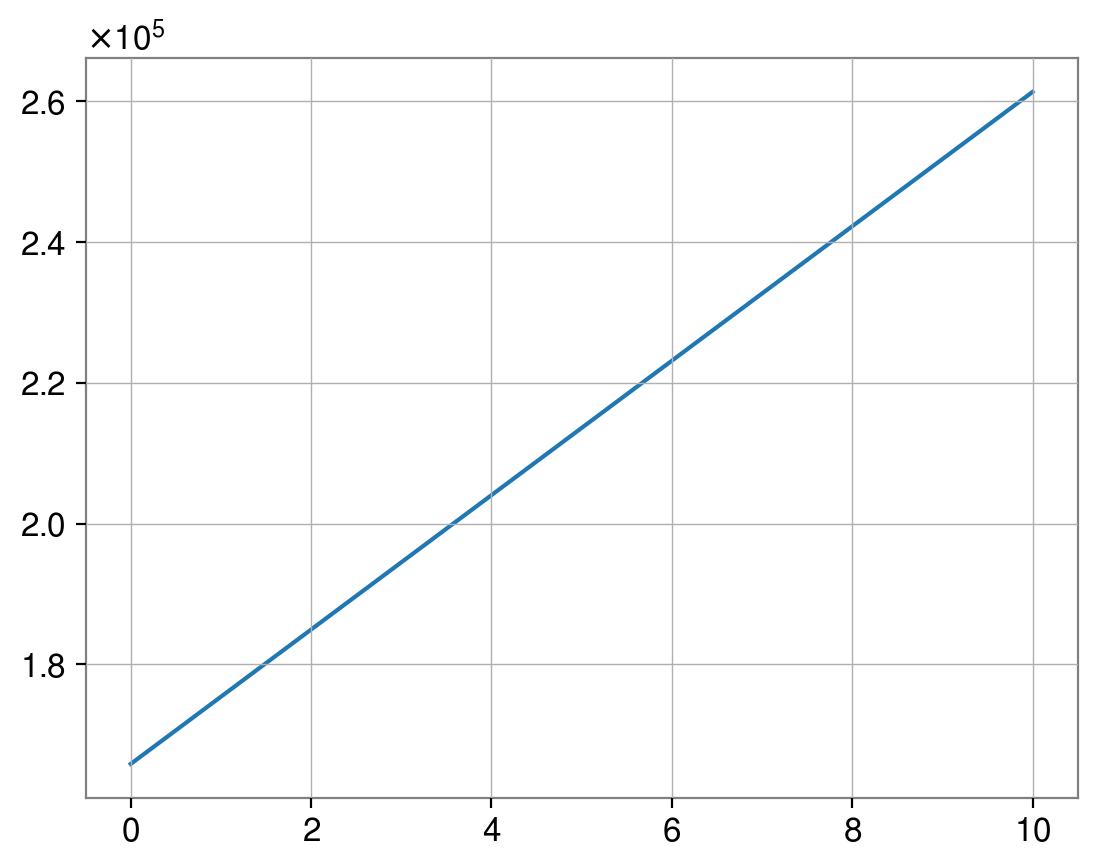

In [85]:
pl.plot(scaling_arr, SNR_arr)

In [86]:
np.polyfit(scaling_arr, SNR_arr, deg=1)

array([  9548.14237225, 165859.63315662])